In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from scipy.interpolate import interp1d
# from plot_funcs import *
from matplotlib import patches

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
# relative difference
def rel_dif(x1, y1, x2, y2):
    # Transform x1, x2, y1, and y2 into log10 space
    log10_x1 = np.log10(x1)
    log10_x2 = np.log10(x2)
    log10_y1 = np.log10(y1)
    log10_y2 = np.log10(y2)

    # Define the common log10(x) range for interpolation
    common_log10_x_min = max(min(log10_x1), min(log10_x2))
    common_log10_x_max = min(max(log10_x1), max(log10_x2))
    common_log10_x = np.linspace(common_log10_x_min, common_log10_x_max, 100)

    # Interpolate log10_y1 and log10_y2 to the common log10_x grid
    interp_log10_y1 = interp1d(log10_x1, log10_y1, kind='linear')(common_log10_x)
    interp_log10_y2 = interp1d(log10_x2, log10_y2, kind='linear')(common_log10_x)

    # Transform interpolated log10 values back to the original space
    interp_y1 = 10**interp_log10_y1
    interp_y2 = 10**interp_log10_y2
    common_x = 10**common_log10_x  # Transform common_log10_x back to original x values

    # Compute (y2 - y1) / y1 in original space
    delta_y = (interp_y2 - interp_y1) / interp_y1
    return common_x, delta_y

In [4]:
def rat_av_cosmo(pred_parent, sim_parent, z, n_HF, exclude=None):
    Ps_pred, nz_ind = load_pred(pred_parent, z, n_HF)
    k_sim, Ps_sim = load_sim(sim_parent, z, nz_ind)
    k, rels = rel_dif(k_sim, Ps_sim, k_sim, Ps_pred)
    rats = rels + 1
    if exclude is not None:  # exclude some cosmologies
        rats = np.delete(rats, exclude, axis=0)
    rat_av = np.mean(rats, axis=0)

    rat_av_k = np.mean(rats, axis=1)
    print('z=', z, rat_av_k)
    # print('z=', z, rats)
    # min and max
    rat_min, rat_max = np.min(rats, axis=0), np.max(rats, axis=0)
    return k, rat_av, rat_min, rat_max, rats

def load_pred(pred_parent, z, n_HF):
    Ps_pred = []
    nz_ind = []  # for matching sim spectra
    for i in range(n_HF):
        file_path = os.path.join(pred_parent, "matter_pow_z%s_l%d.txt" % (z, i))
        if os.path.exists(file_path):
            # print(f"The file {file_path} exists.")
            data = np.loadtxt(file_path,)
            data = data.transpose()
            P_pred = data[-1]
            Ps_pred.append(P_pred)
            nz_ind.append(i)
        else:
            print(f"The file {file_path} does not exist.")
            continue
    Ps_pred = np.array(Ps_pred)
    return Ps_pred, nz_ind

def load_sim(sim_base, z, nz_ind):
    file_path = os.path.join(sim_base + "_z%s" % z, 'train_output_fidelity_1.txt')
    k_path = os.path.join(sim_base + "_z%s" % z, 'kf.txt')
    lg_Ps = np.loadtxt(file_path)
    lg_Ps = lg_Ps[nz_ind]
    Ps_sim = 10**lg_Ps
    lg_k = np.loadtxt(k_path, usecols=(0))
    k_sim = 10**lg_k
    return k_sim, Ps_sim

z= 0 [1.00127038 0.99501236 0.99911363 1.00530469 1.00080891 0.98815935
 0.99921657 0.99771391 1.00108186 1.00339003 1.00743544 1.00269058
 0.99719277 0.9988941  1.00629825]
z= 0 [0.99987892 0.99108538 1.00035674 0.99719763 1.00266647 1.00446534
 0.99888203 0.9985778  0.99916489 1.00040599 1.00215189 0.99963653
 0.99947821 1.00313735 1.00530759]
z= 0.2 [0.99921965 0.99971665 0.998821   0.9999524  0.999572   0.9975838
 1.00119772 1.0005227  0.99938164 0.99974318 1.00173602 0.99944204
 0.99816971 0.99989953 1.00116616]
z= 0.2 [0.99947127 0.99904982 0.99994237 1.00039962 1.00049665 1.0022759
 0.99966653 1.00074382 0.99971813 0.99951478 0.99970353 0.9984804
 0.99925677 1.00103369 1.0016127 ]
z= 0.5 [1.00040713 1.00120336 0.99944723 1.00114677 0.99907811 0.99660667
 1.00107638 1.00012602 0.99859146 0.99886883 1.00146644 1.00001494
 0.99796052 0.9994561  1.0012404 ]
z= 0.5 [1.00037981 1.00111177 0.999749   1.00030967 1.00167859 0.99997762
 0.99919466 1.00031129 0.9982055  0.99922071 0.999593

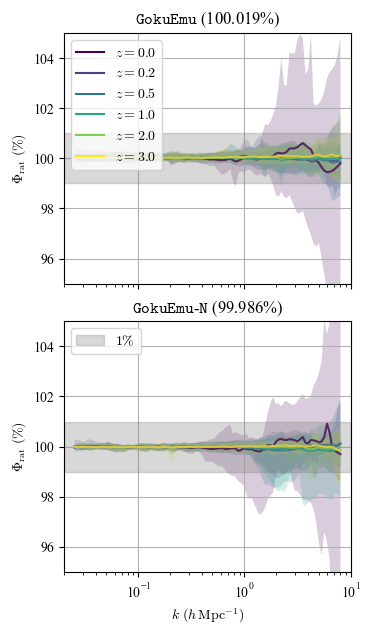

In [10]:
# relative
# sim_parent = "/work2/01317/yyang440/frontera/cosmo_11p_sims/data_for_emu" # frontera
sim_combined_base = "../data/combined/matter_power_1128_Box1000_Part750_36_Box1000_Part3000" 
pred_combined_parent = './loo_combined_upper/'

sim_N_base = "../data/narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000" 
pred_N_parent = './loo_narrow_upper/'

fig, axes = plt.subplots(2, 1, figsize=(3.7, 7.), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.15)
plt.rcParams['font.family'] = 'Times New Roman'

# Set math font style
plt.rcParams['mathtext.fontset'] = 'cm'

zs = np.array([0,0.2, 0.5, 1, 2, 3, 4, 9, 49, 99])
zs_str = ['0', '0.2', '0.5', '1', '2', '3', '4', '9', '49', '99']
a = 1/(1+zs)

cmap = "viridis"
cmap = plt.get_cmap(cmap)
color_list = [x for x in cmap(np.arange(len(zs[:6]))/(len(zs[:6])-1))]

# axes[0].plot([], [], color='black', label='HF')
# # axes[0].plot([], [], color='black', linestyle=':', label='L1')
# axes[0].plot([], [], color='black', linestyle='--', label='Linear')
rat_zs = []
rat_zs_N = []

for i, scale in enumerate(a):
    if i==6:  # redshifts
        break
    c = color_list[i]

    k, rat, rat_min, rat_max, rats = rat_av_cosmo(pred_N_parent, sim_N_base, zs_str[i], 15)
    rat_zs_N.append(rat.mean())

    axes[1].plot(k, rat/1e-2, color=c)
    axes[1].fill_between(k, rat_min/1e-2, rat_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')

    k, rat, rat_min, rat_max, rats = rat_av_cosmo(pred_combined_parent, sim_combined_base, zs_str[i], 36, exclude=[i for i in range(21)])
    rat_zs.append(rat.mean())

    axes[0].plot(k, rat/1e-2, color=c, label=r"$z=%.1f$" % zs[i])
    axes[0].fill_between(k, rat_min/1e-2, rat_max/1e-2, facecolor=c, alpha=0.2, edgecolor='none')
    
rat_zs = np.array(rat_zs)
rat_zs_mean = rat_zs.mean()
print('average over k and z (combined):', rat_zs_mean)

rat_zs_N = np.array(rat_zs_N)
rat_zs_mean_N = rat_zs_N.mean()
print('average over k and z (N-only):', rat_zs_mean_N)
    

    # if labels is not None:

# title
axes[0].set_title(r'$\tt{GokuEmu}$' + f' ({100*rat_zs_mean:.3f}%)')
axes[1].set_title(r'$\tt{GokuEmu}$'+'-' + r'$\tt{N}$' + f' ({100*rat_zs_mean_N:.3f}%)')


axes[0].set_ylabel(r'$\Phi_{\mathrm{rat}}\ (\%)$')
axes[1].set_ylabel(r'$\Phi_{\mathrm{rat}}\ (\%)$')
# plt.xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# plt.ylabel(r'$P(k)\ (h^{-3}\mathrm{Mpc}^3)$')
# axes[0].plot([], [], color='black', label='HF')
# axes[0].plot([], [], color='black', label='HF w.r.t. Linear')
# axes[0].plot([], [], color='black', linestyle='--', label='L2 w.r.t. HF')
# axes[0].set_ylim(0., 5)
axes[1].set_ylim(95, 105)
axes[0].set_xscale('log')
axes[1].set_xlabel(r'$k\ (h\,\mathrm{Mpc}^{-1})$')
# axes[0].set_ylabel(r'$(P_\mathrm{HF}-P_\mathrm{Li})/P_\mathrm{Li}$')

xlim1 = .02
xlim2 = 10
axes[0].set_xlim(xlim1, xlim2)

square = patches.Rectangle((xlim1, 99), xlim2-xlim1, 2, color='gray', alpha=.3, zorder=2)  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
axes[0].add_patch(square)
# axes[0].add_patch(square1)
axes[0].legend(loc='upper left')

square1 = patches.Rectangle((xlim1, 99), xlim2-xlim1, 2, color='gray', alpha=.3, zorder=2, label=r'$1\%$')  # alpha ranges from 0 (transparent) to 1 (opaque)
# Add the square to the axes
axes[1].add_patch(square1)
# axes[0].add_patch(square1)
axes[1].legend(loc='upper left')

# grid true
for ax in axes:
    ax.grid(True)


# plt.show()
# plt.savefig('loo_against_N.pdf', bbox_inches='tight')